  Order Priority  Discount offered  Unit Price  Freight Expenses Freight Mode  \
0           High              0.06       40.98              2.99  Regular Air   
1           High              0.05      155.06              7.07  Regular Air   
2           High              0.09        9.11              2.15  Express Air   
3           High              0.08       15.04              1.97  Regular Air   
4           High              0.03        4.26              1.20  Regular Air   

              Segment    Product Type Product Sub-Category Product Container  \
0      Personel Usage  Processed Meat                Bacon         Small Box   
1  Hotels / Hospitals  Processed Meat      Fresh Water Eel         Small Box   
2      Personel Usage  Processed Meat        Smoked Salmon          Wrap Bag   
3      Personel Usage  Processed Meat        Smoked Salmon          Wrap Bag   
4    Restaurant Chain  Processed Meat            Foie Gras          Wrap Bag   

            State       City Reg

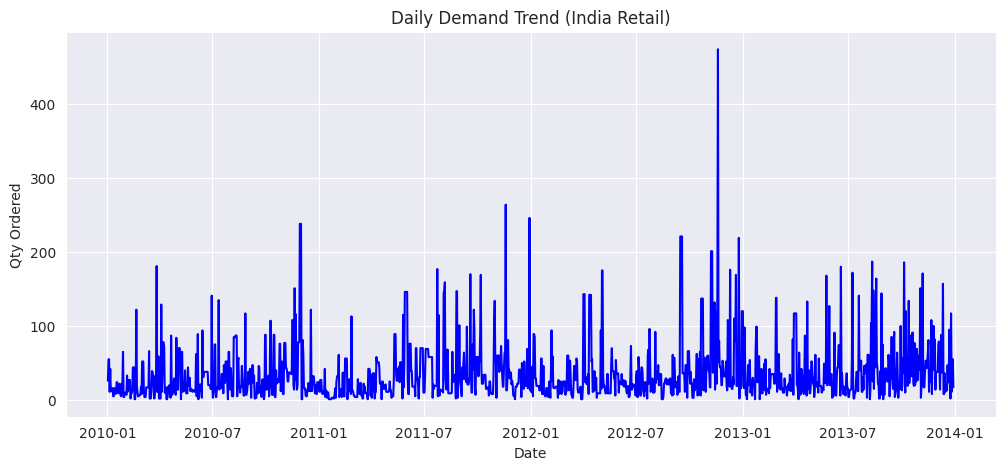

ADF Statistic: -20.692687401510987
p-value: 0.0


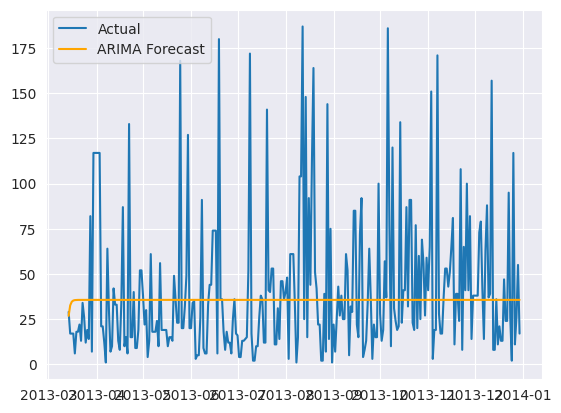

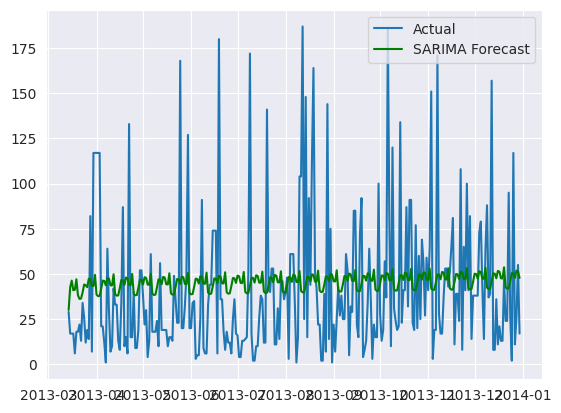

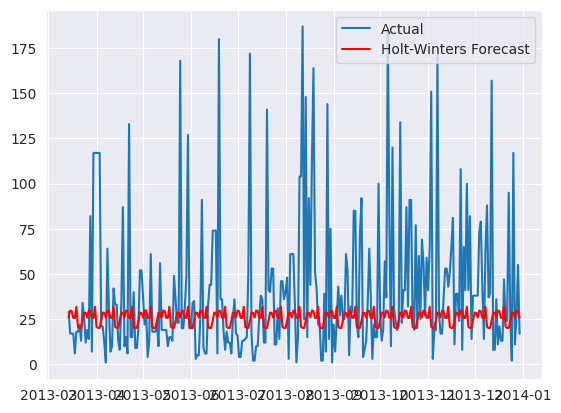

          Model       RMSE        MAE        MAPE
0         ARIMA  39.094336  27.193757  184.417407
1        SARIMA  38.847550  29.976925  243.643626
2  Holt-Winters  41.555893  26.612430  134.043958


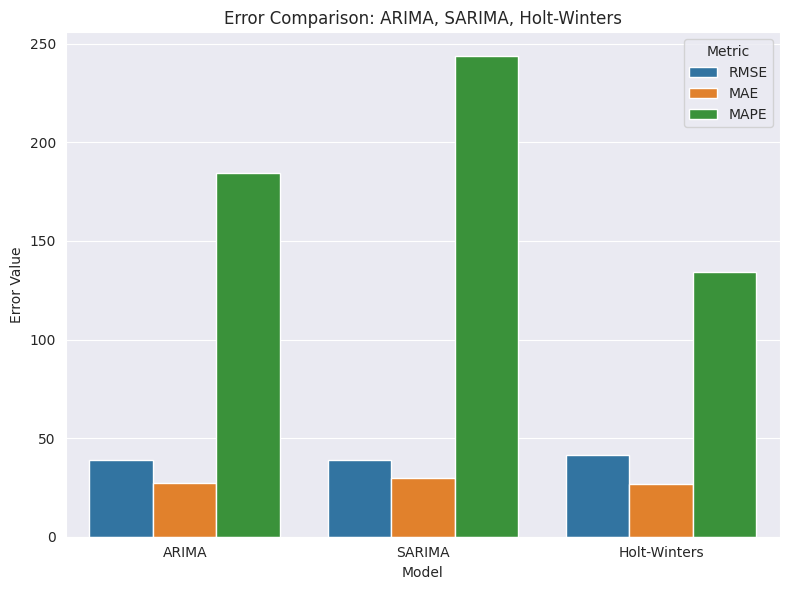

Best model for minimizing large errors (lowest RMSE): SARIMA
Lowest RMSE value: 38.85


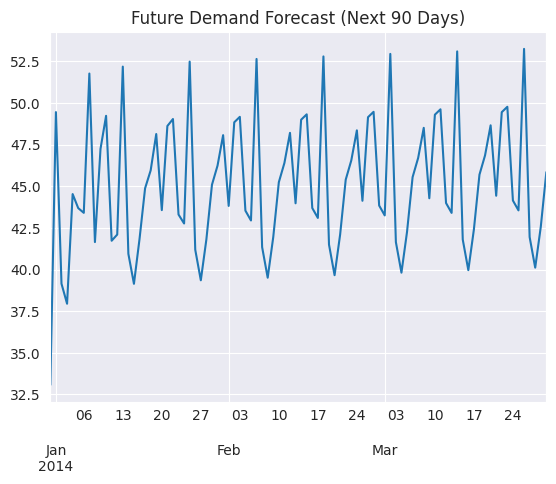

Saved:
 - forecasts_output/final_2014_onwards_forecasts.csv
 - forecasts_output/per_group_full_history_and_test_forecasts.csv
 - forecasts_output/per_group_evaluation.csv
 - plots in forecasts_output/plots


In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

INPUT_FILE = "INDIA_RETAIL_DATA.xlsx"
DATE_COL = "Order Date"
QTY_COL = "QtyOrdered"
PRODUCT_COL = "Product Type"
SUBCAT_COL = "Product Sub-Category"
MIN_MONTHS = 12
TEST_FRAC = 0.2
N_FORECAST_MONTHS = 6
FUTURE_FORECAST_YEAR = 2014
OUTPUT_DIR = "forecasts_output"
PLOTS_DIR = os.path.join(OUTPUT_DIR, "plots")
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

def evaluate_simple(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    true_masked = np.array(true)
    mask = true_masked != 0
    mape = np.mean(np.abs((true_masked[mask] - pred[mask]) / true_masked[mask])) * 100 if mask.any() else np.nan
    return rmse, mae, mape

def evaluate_dict(true, pred):
    true = np.array(true)
    pred = np.array(pred)
    mask = true != 0
    mape = np.mean(np.abs((true[mask] - pred[mask]) / true[mask])) * 100 if mask.any() else np.nan
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape}

def safe_sarimax_forecast(train, steps, seasonal_periods=12, order=(1,1,1), seasonal_order=(1,1,1,12)):
    try:
        model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
        fit = model.fit(disp=False, maxiter=50)
        fc = fit.forecast(steps)
        return fc, fit
    except Exception as e:
        return None, None

def ets_forecast(train, steps, seasonal_periods=12):
    try:
        model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=seasonal_periods, initialization_method="estimated")
        fit = model.fit(optimized=True)
        fc = fit.forecast(steps)
        return fc, fit
    except Exception as e:
        return None, None

df_full = pd.read_excel(INPUT_FILE)

print(df_full.head())
print(df_full.info())

df_full['Order Date'] = pd.to_datetime(df_full['Order Date'], errors='coerce')
df_full.sort_values(by='Order Date', inplace=True)

df_daily = df_full[['Order Date', 'QtyOrdered']].copy()
df_daily = df_daily.groupby('Order Date').sum().reset_index()

df_daily['QtyOrdered']= df_daily['QtyOrdered'].interpolate(method='linear')

df_daily.set_index('Order Date', inplace=True)
df_daily = df_daily.asfreq('D')
df_daily['QtyOrdered'].fillna(method='ffill', inplace=True)

plt.figure(figsize=(12,5))
plt.plot(df_daily['QtyOrdered'], color='blue')
plt.title("Daily Demand Trend (India Retail)")
plt.xlabel("Date")
plt.ylabel("Qty Ordered")
plt.show()

adf_test = adfuller(df_daily['QtyOrdered'])
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])

train_size = int(len(df_daily) * 0.8)
train, test = df_daily.iloc[:train_size], df_daily.iloc[train_size:]

model_arima = ARIMA(train['QtyOrdered'], order=(1,1,1))
fit_arima = model_arima.fit()
forecast_arima = fit_arima.forecast(len(test))
plt.plot(test.index, test['QtyOrdered'], label='Actual')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast', color='orange')
plt.legend()
plt.show()

model_sarima = SARIMAX(train['QtyOrdered'], order=(1,1,1), seasonal_order=(1,1,1,12))
fit_sarima = model_sarima.fit(disp=False)
forecast_sarima = fit_sarima.forecast(len(test))
plt.plot(test.index, test['QtyOrdered'], label='Actual')
plt.plot(test.index, forecast_sarima, label='SARIMA Forecast', color='green')
plt.legend()
plt.show()

model_hw = ExponentialSmoothing(train['QtyOrdered'], seasonal='add', seasonal_periods=12)
fit_hw = model_hw.fit()
forecast_hw = fit_hw.forecast(len(test))
plt.plot(test.index, test['QtyOrdered'], label='Actual')
plt.plot(test.index, forecast_hw, label='Holt-Winters Forecast', color='red')
plt.legend()
plt.show()

metrics = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'Holt-Winters'],
    'RMSE': [
        evaluate_simple(test['QtyOrdered'], forecast_arima)[0],
        evaluate_simple(test['QtyOrdered'], forecast_sarima)[0],
        evaluate_simple(test['QtyOrdered'], forecast_hw)[0]
    ],
    'MAE': [
        evaluate_simple(test['QtyOrdered'], forecast_arima)[1],
        evaluate_simple(test['QtyOrdered'], forecast_sarima)[1],
        evaluate_simple(test['QtyOrdered'], forecast_hw)[1]
    ],
    'MAPE': [
        evaluate_simple(test['QtyOrdered'], forecast_arima)[2],
        evaluate_simple(test['QtyOrdered'], forecast_sarima)[2],
        evaluate_simple(test['QtyOrdered'], forecast_hw)[2]
    ]
})
print(metrics)

metrics_melted = metrics.melt(id_vars="Model", value_vars=["RMSE", "MAE", "MAPE"],
                              var_name="Metric", value_name="Error")

plt.figure(figsize=(8,6))
sns.barplot(data=metrics_melted, x="Model", y="Error", hue="Metric")
plt.title("Error Comparison: ARIMA, SARIMA, Holt-Winters")
plt.ylabel("Error Value")
plt.xlabel("Model")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

best_rmse_model = metrics.loc[metrics['RMSE'].idxmin(), 'Model']
best_rmse_value = metrics['RMSE'].min()

print(f"Best model for minimizing large errors (lowest RMSE): {best_rmse_model}")
print(f"Lowest RMSE value: {best_rmse_value:.2f}")

final_model = SARIMAX(df_daily['QtyOrdered'], order=(1,1,1), seasonal_order=(1,1,1,12)).fit(disp=False)
future_forecast = final_model.forecast(90)
future_forecast.plot(title="Future Demand Forecast (Next 90 Days)")
plt.show()

metrics.to_csv("Model_Evaluation_Results.csv", index=False)

df = pd.read_excel(INPUT_FILE)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce')

df[QTY_COL] = pd.to_numeric(df[QTY_COL], errors='coerce').fillna(0)
df['Sales'] = pd.to_numeric(df.get('Sales', 0), errors='coerce').fillna(0)
df['Profit'] = pd.to_numeric(df.get('Profit', 0), errors='coerce').fillna(0)
df = df.dropna(subset=[DATE_COL, PRODUCT_COL, SUBCAT_COL])

df['YearMonth'] = df[DATE_COL].dt.to_period('M').dt.to_timestamp()
agg = df.groupby(['YearMonth', PRODUCT_COL, SUBCAT_COL]).agg({
    QTY_COL: 'sum',
    'Sales': 'sum',
    'Profit': 'sum'
}).reset_index().rename(columns={'YearMonth': 'Month'})

groups = agg.groupby([PRODUCT_COL, SUBCAT_COL])
all_forecasts = []
eval_rows = []
for (ptype, subcat), g in groups:
    g = g.sort_values('Month').set_index('Month')
    idx = pd.date_range(start=g.index.min(), end=g.index.max(), freq='MS')
    g = g.reindex(idx)
    g[QTY_COL] = g[QTY_COL].fillna(0)
    g['Sales'] = g['Sales'].fillna(0)
    g['Profit'] = g['Profit'].fillna(0)

    series = g[QTY_COL]
    n_periods = len(series)
    if series.sum() == 0:
        continue
    test_size = max(1, int(np.ceil(n_periods * TEST_FRAC)))
    train = series.iloc[:-test_size] if test_size < n_periods else series.iloc[:-1]
    test = series.iloc[len(train):]
    used_model = None
    forecast_test = None
    fitted_obj = None

    if len(train) >= MIN_MONTHS:
        fc, fit = safe_sarimax_forecast(train, steps=len(test), seasonal_periods=12)
        if fc is not None:
            used_model = "SARIMAX(1,1,1)x(1,1,1,12)"
            forecast_test = fc
            fitted_obj = fit
        else:
            fc, fit = ets_forecast(train, steps=len(test), seasonal_periods=12)
            if fc is not None:
                used_model = "ETS(add)"
                forecast_test = fc
                fitted_obj = fit
    else:
        sp = min(12, max(1, len(series)))
        fc, fit = ets_forecast(train, steps=len(test), seasonal_periods=sp)
        if fc is not None:
            used_model = f"ETS(short_sp={sp})"
            forecast_test = fc
            fitted_obj = fit

    if forecast_test is None:
        if n_periods >= 12:
            monthly_means = series.groupby(series.index.month).mean()
            forecast_test = pd.Series([monthly_means[m.month] if m.month in monthly_means.index else series.mean()
                                       for m in test.index], index=test.index)
            used_model = "SeasonalMeanFallback"
        else:
            last_val = train.iloc[-1] if len(train) > 0 else series.iloc[-1]
            forecast_test = pd.Series([last_val] * len(test), index=test.index)
            used_model = "LastValueFallback"


    metrics = evaluate_dict(test.values, forecast_test.values)
    eval_rows.append({
        PRODUCT_COL: ptype,
        SUBCAT_COL: subcat,
        'n_months': n_periods,
        'Model': used_model,
        'RMSE': metrics['RMSE'],
        'MAE': metrics['MAE'],
        'MAPE': metrics['MAPE']
    })

    last_actual_date = series.index.max()
    target_end_date = pd.to_datetime(f'{FUTURE_FORECAST_YEAR}-12-01') + pd.offsets.MonthEnd(0)

    if last_actual_date.to_period('M') < target_end_date.to_period('M'):
        months_to_forecast = ((target_end_date.to_period('M') - last_actual_date.to_period('M'))).n
    else:
        months_to_forecast = N_FORECAST_MONTHS

    future_index = pd.date_range(start=last_actual_date + pd.offsets.MonthBegin(1), periods=months_to_forecast, freq='MS')
    N_FORECAST_MONTHS_FINAL = len(future_index)
    final_fc = None
    if used_model and "SARIMAX" in used_model:
        try:
            final_model = SARIMAX(series, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
            final_fit = final_model.fit(disp=False, maxiter=50)
            final_fc = final_fit.forecast(N_FORECAST_MONTHS_FINAL)
        except Exception:
            final_fc, _ = ets_forecast(series, steps=N_FORECAST_MONTHS_FINAL, seasonal_periods=12)
    elif used_model and used_model.startswith("ETS"):
        final_fc, final_fit = ets_forecast(series, steps=N_FORECAST_MONTHS_FINAL, seasonal_periods=min(12, max(1, len(series))))
    else:
        if n_periods >= 12:
            monthly_means = series.groupby(series.index.month).mean()
            final_fc = pd.Series([monthly_means[m.month] if m.month in monthly_means.index else series.mean() for m in future_index], index=future_index)
        else:
            last_val = series.iloc[-1]
            final_fc = pd.Series([last_val] * N_FORECAST_MONTHS_FINAL, index=future_index)

    for idx, val in zip(test.index, forecast_test.values):
        all_forecasts.append({
            'Product Type': ptype,
            'Product Sub-Category': subcat,
            'Type': 'test_forecast',
            'Period': idx,
            'Forecast_Qty': float(np.round(val)),
            'Model': used_model
        })
    for idx, val in zip(series.index, series.values):
        all_forecasts.append({
            'Product Type': ptype,
            'Product Sub-Category': subcat,
            'Type': 'actual',
            'Period': idx,
            'Forecast_Qty': float(val),
            'Model': 'actual'
        })
    for idx, val in zip(final_fc.index, final_fc.values):
        if idx.year >= FUTURE_FORECAST_YEAR:
            all_forecasts.append({
                'Product Type': ptype,
                'Product Sub-Category': subcat,
                'Type': 'future_forecast',
                'Period': idx,
                'Forecast_Qty': float(np.round(val)),
                'Model': used_model
            })

    plt.figure(figsize=(10,4))
    plt.plot(series.index, series.values, label='Actual', marker='o')
    plt.plot(test.index, forecast_test.values, label='Test Forecast', marker='o')
    plt.plot(final_fc.index, final_fc.values, label=f'Future {N_FORECAST_MONTHS_FINAL}m Forecast', marker='o')
    plt.title(f"{ptype} / {subcat}  (n_months={n_periods})  Model={used_model}")
    plt.xlabel("Month")
    plt.ylabel("QtyOrdered")
    plt.legend()
    plt.tight_layout()
    safe_name = f"{str(ptype)[:30]}__{str(subcat)[:30]}".replace("/", "_").replace(" ", "_")
    plt.savefig(os.path.join(PLOTS_DIR, f"{safe_name}.png"))
    plt.close()

forecasts_df = pd.DataFrame(all_forecasts)
forecasts_df['Period'] = pd.to_datetime(forecasts_df['Period'])

future_forecasts_only = forecasts_df[
    (forecasts_df['Type'] == 'future_forecast') &
    (forecasts_df['Period'].dt.year >= FUTURE_FORECAST_YEAR)
]

future_forecasts_only.to_csv(os.path.join(OUTPUT_DIR, "final_2014_onwards_forecasts.csv"), index=False)

forecasts_df.to_csv(os.path.join(OUTPUT_DIR, "per_group_full_history_and_test_forecasts.csv"), index=False)

eval_df = pd.DataFrame(eval_rows)
eval_df.to_csv(os.path.join(OUTPUT_DIR, "per_group_evaluation.csv"), index=False)

print("Saved:")
print(" -", os.path.join(OUTPUT_DIR, "final_2014_onwards_forecasts.csv"))
print(" -", os.path.join(OUTPUT_DIR, "per_group_full_history_and_test_forecasts.csv"))
print(" -", os.path.join(OUTPUT_DIR, "per_group_evaluation.csv"))
print(" - plots in", PLOTS_DIR)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')